In [32]:
#modules for cox penalized models
!pip install scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#connect CoLab with GoogleDrive
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import load_diabetes

In [5]:
#import genomic data
input_file = 'drive/MyDrive/MSK/data_mrna_seq_v2_rsem_zscores_ref_normal_samples.txt'
raw_data = pd.read_table(input_file, sep='\t', header=None)
raw_data.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

,0,1,2,3,4,5,6,7,8,9,...,584,585,586,587,588,589,590,591,592,593
0,Hugo_Symbol,Entrez_Gene_Id,TCGA-3L-AA1B-01,TCGA-4N-A93T-01,TCGA-4T-AA8H-01,TCGA-5M-AAT4-01,TCGA-5M-AAT5-01,TCGA-5M-AAT6-01,TCGA-5M-AATA-01,TCGA-5M-AATE-01,...,TCGA-AG-A01N-01,TCGA-AG-A01W-01,TCGA-AG-A01Y-01,TCGA-AG-A020-01,TCGA-AG-A025-01,TCGA-AG-A026-01,TCGA-AG-A02G-01,TCGA-AG-A02N-01,TCGA-AG-A02X-01,TCGA-AG-A032-01
1,NaN,100130426,0.7981,-5.5534,-5.5534,-5.5534,-5.5534,-5.5534,-5.5534,-5.5534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,100133144,1.6905,-0.2648,0.8189,0.5066,1.1235,-0.4049,0.3831,1.0481,...,1.4869,1.3706,1.9623,0.8561,1.1415,1.596,1.4207,1.8004,0.9528,0.3632
3,UBE2Q2P2,100134869,1.9068,-0.4676,1.2713,2.2447,2.4542,1.8196,1.2959,0.3629,...,1.8388,2.0089,3.3307,1.4038,2.295,2.5816,2.3138,-1.1337,-0.0085,1.6404
4,HMGB1P1,10357,0.7458,0.7168,0.7258,0.7753,2.1804,1.8444,0.3856,1.9721,...,2.4532,3.4639,3.0588,2.9039,3.2584,2.4178,2.9951,2.7559,3.0254,3.2484


In [6]:
#output patient_id
observations = raw_data.iloc[:1, 2:].transpose()
observations.rename(columns={0:'sample_id'}, inplace=True)
observations['patient_id'] = observations['sample_id'].str[:12]
observations['patient_group'] = observations['sample_id'].str[:7]

observations.head()

,sample_id,patient_id,patient_group
2,TCGA-3L-AA1B-01,TCGA-3L-AA1B,TCGA-3L
3,TCGA-4N-A93T-01,TCGA-4N-A93T,TCGA-4N
4,TCGA-4T-AA8H-01,TCGA-4T-AA8H,TCGA-4T
5,TCGA-5M-AAT4-01,TCGA-5M-AAT4,TCGA-5M
6,TCGA-5M-AAT5-01,TCGA-5M-AAT5,TCGA-5M


In [7]:
observations.shape

(592, 3)

In [8]:
observations['sample_id'].nunique()

592

In [9]:
observations['patient_id'].nunique()

592

In [10]:
observations['patient_group'].nunique()

37

In [11]:
data_matrix = raw_data.iloc[1:,2:].transpose()  

In [12]:
#unique percentage of missing data in columns
ptg_missing_col = data_matrix.isna().mean().round(4)
unique_ptg = set(ptg_missing_col)
print(unique_ptg)

{0.3834, 0.0, 1.0}


In [13]:
#deal with missing data and set index
data_matrix.fillna(0.0, inplace=True)
data_matrix.insert(0,'patient_id',observations['patient_id'])
data_matrix.columns = data_matrix.columns.astype('str')
data_matrix.set_index('patient_id', inplace=True)


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


In [14]:
data_matrix.shape

(592, 20531)

In [15]:
data_matrix.columns

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '20522', '20523', '20524', '20525', '20526', '20527', '20528', '20529',
       '20530', '20531'],
      dtype='object', length=20531)

In [16]:
#set index for gene symbol and id
variables = raw_data.iloc[1:, 0:2]
variables.rename(columns = {0:'Hugo_Symbol', 1:'Entrez_Gene_Id'}, inplace=True)
variables['index'] = variables.index
variables['index'] = variables['index'].astype('str')
variables.set_index('index', inplace=True)

variables.head()

,Hugo_Symbol,Entrez_Gene_Id
index,,
1,NaN,100130426
2,NaN,100133144
3,UBE2Q2P2,100134869
4,HMGB1P1,10357
5,NaN,10431


In [17]:
#change the data type of entrez gene id for column names
variables['Entrez_Gene_Id'] =variables['Entrez_Gene_Id'].astype('str')
variables['Entrez_Gene_Id'].dtype
variables

,Hugo_Symbol,Entrez_Gene_Id
index,,
1,NaN,100130426
2,NaN,100133144
3,UBE2Q2P2,100134869
4,HMGB1P1,10357
5,NaN,10431
...,...,...
20527,ZYG11A,440590
20528,ZYG11B,79699
20529,ZYX,7791


In [18]:
#change column names
data_matrix.columns = variables['Entrez_Gene_Id']

In [19]:
data_matrix.shape

(592, 20531)

In [20]:
#import patient data
input_file = 'drive/MyDrive/MSK/data_clinical_patient.csv'
raw_patient = pd.read_table(input_file, sep=',', header=None)


In [21]:
#Create dataset with survival time

patient_survival = raw_patient.iloc[1:, [0, 29, 30]]
patient_survival.rename(columns = {0:'patient_id', 29:'OS_STATUS', 30:'OS_MONTH'}, inplace=True)
patient_survival['OS'] = patient_survival['OS_STATUS'].str[0]

patient_survival.columns = patient_survival.columns.astype('category')
patient_survival['OS_MONTH'] = patient_survival['OS_MONTH'].astype('float64')
patient_survival = patient_survival.dropna()
patient_survival.set_index('patient_id', inplace=True)
patient_survival.head()


,OS_STATUS,OS_MONTH,OS
patient_id,,,
TCGA-3L-AA1B,0:LIVING,15.616267,0
TCGA-4N-A93T,0:LIVING,4.799947,0
TCGA-4T-AA8H,0:LIVING,12.657396,0
TCGA-5M-AAT4,1:DECEASED,1.610941,1
TCGA-5M-AAT6,1:DECEASED,9.534142,1


In [22]:
#find discrepancies between patient.patient_id and data_matrix.patient_id
dismatch = patient_survival.reindex(patient_survival.index.difference(data_matrix.index))
print(dismatch)

               OS_STATUS   OS_MONTH OS
patient_id                            
TCGA-AA-3558    0:LIVING  20.975113  0
TCGA-AF-2689  1:DECEASED  39.484499  1


In [23]:
#merge genomic data with cancer type through inner join using patient_id
matrix_merged_new = pd.merge(data_matrix, patient_survival,on='patient_id')
matrix_merged_new = matrix_merged_new.drop(['OS_STATUS'], axis = 1)
matrix_merged_new

/usr/local/lib/python3.8/dist-packages/pandas/core/reshape/merge.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  return op.get_result()


,100130426,100133144,100134869,10357,10431,136542,155060,26823,280660,317712,...,7789,158586,79364,440590,79699,7791,23140,26009,OS_MONTH,OS
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-3L-AA1B,0.7981,1.6905,1.9068,0.7458,0.3572,0.0,4.9963,2.5034,0.0,0.0,...,1.5265,1.9041,2.1862,0.5758,-1.7449,1.2799,-2.3005,2.1609,15.616267,0
TCGA-4N-A93T,-5.5534,-0.2648,-0.4676,0.7168,2.4251,0.0,5.4312,-0.6054,0.0,0.0,...,-0.6711,0.7206,2.4134,-1.1532,-3.9237,0.6431,-2.5295,-2.0323,4.799947,0
TCGA-4T-AA8H,-5.5534,0.8189,1.2713,0.7258,1.0227,0.0,3.8785,3.8294,0.0,0.0,...,-1.5396,0.4724,2.0699,-1.7828,-1.0130,0.5523,-0.6071,0.1905,12.657396,0
TCGA-5M-AAT4,-5.5534,0.5066,2.2447,0.7753,2.801,0.0,4.5983,2.8292,0.0,0.0,...,0.5327,2.7372,3.4521,-1.2117,-2.4370,0.4180,-2.7636,0.5772,1.610941,1
TCGA-5M-AAT6,-5.5534,-0.4049,1.8196,1.8444,1.3267,0.0,2.9882,1.4178,0.0,0.0,...,-0.1209,0.2595,1.9233,2.5147,-2.0835,1.2477,-2.2504,1.6455,9.534142,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AG-A026,0.0,1.596,2.5816,2.4178,1.3337,0.0,3.9956,0.0,0.0,0.0,...,0.7431,1.8910,2.5890,-1.5797,-0.7810,0.2106,-2.6383,0.2219,1.939705,1
TCGA-AG-A02G,0.0,1.4207,2.3138,2.9951,0.7512,0.0,4.9852,0.0,0.0,0.0,...,2.2577,4.0414,2.5358,-1.7828,-2.6587,0.0494,-1.7385,-1.9103,38.958477,1
TCGA-AG-A02N,0.0,1.8004,-1.1337,2.7559,1.0474,0.0,1.9729,0.0,0.0,0.0,...,1.4417,3.7918,3.7183,-1.4066,0.0767,-0.4717,-2.6534,3.2270,61.971924,0


In [24]:
X = matrix_merged_new.drop(['OS_MONTH', 'OS'], axis=1)
y_tem = pd.DataFrame({'OS':matrix_merged_new['OS'],'OS_MONTH': matrix_merged_new['OS_MONTH']})
y_tem['OS'] = y_tem['OS'].astype(bool)
y = y_tem.to_records(index=False)

rebalance dataset

In [25]:
#rebalance
! pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


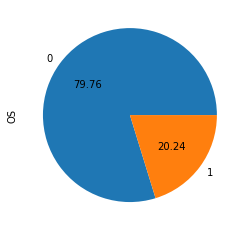

In [26]:
matrix_merged_new['OS'].value_counts().plot.pie(autopct='%.2f')

Original dataset shape Counter({'0': 469, '1': 119})
Resampled dataset shape Counter({'0': 469, '1': 469})


,0,1,2,3,4,5,6,7,8,9,...,20522,20523,20524,20525,20526,20527,20528,20529,20530,20531
0,0.7981,1.690500,1.906800,0.745800,0.357200,0.0,4.996300,2.503400,0.0,0.0,...,0.125400,1.526500,1.904100,2.186200,0.575800,-1.744900,1.279900,-2.300500,2.160900,15.616267
1,-5.5534,-0.264800,-0.467600,0.716800,2.425100,0.0,5.431200,-0.605400,0.0,0.0,...,-0.727000,-0.671100,0.720600,2.413400,-1.153200,-3.923700,0.643100,-2.529500,-2.032300,4.799947
2,-5.5534,0.818900,1.271300,0.725800,1.022700,0.0,3.878500,3.829400,0.0,0.0,...,1.320800,-1.539600,0.472400,2.069900,-1.782800,-1.013000,0.552300,-0.607100,0.190500,12.657396
3,-5.5534,0.506600,2.244700,0.775300,2.801000,0.0,4.598300,2.829200,0.0,0.0,...,2.420800,0.532700,2.737200,3.452100,-1.211700,-2.437000,0.418000,-2.763600,0.577200,1.610941
4,-5.5534,-0.404900,1.819600,1.844400,1.326700,0.0,2.988200,1.417800,0.0,0.0,...,1.946700,-0.120900,0.259500,1.923300,2.514700,-2.083500,1.247700,-2.250400,1.645500,9.534142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,0.0000,0.500751,2.866230,-0.755069,0.075634,0.0,6.253592,0.000000,0.0,0.0,...,-0.382553,2.582366,1.128965,3.225458,-1.782800,-5.008863,1.313154,-1.877556,-2.775167,13.326329
934,0.0000,1.189043,1.673784,2.199286,0.806856,0.0,1.989467,0.000000,0.0,0.0,...,1.351981,1.402576,1.939177,1.166569,-1.688513,-1.164594,1.021585,-2.583033,3.029472,15.413018
935,-5.5534,1.235373,1.916810,0.105869,0.806343,0.0,1.470194,1.146729,0.0,0.0,...,0.913449,0.217135,1.329998,1.314287,-1.268616,-1.042672,0.373470,-1.615166,1.501030,76.422617
936,-5.5534,1.196312,1.278700,2.399398,-0.024511,0.0,3.751545,0.107252,0.0,0.0,...,0.931540,3.003191,3.215846,2.669779,-0.913599,-1.639248,-0.151368,-1.905233,1.730717,29.532556


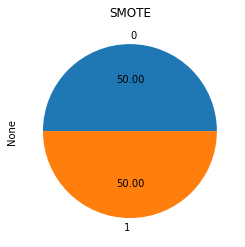

In [27]:
#SMOTE Oversampling
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

y_new = matrix_merged_new.loc[:, 'OS']
X_new = matrix_merged_new.drop(['OS'], axis=1)

print('Original dataset shape %s' % Counter(y_new))

X_new=np.array(X_new)

smo = SMOTE(random_state=42)
X_res, y_res = smo.fit_resample(X_new, y_new.ravel())
print('Resampled dataset shape %s' % Counter(y_res))

X_res1 = pd.DataFrame(X_res)
y_res1= pd.Series(y_res)
ax = y_res1.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title('SMOTE')

X_res1

In [28]:
#Concat rebalanced dataset

merged_x = X_res1.drop([20531],axis =1)
merged_x.columns = variables['Entrez_Gene_Id']


merged_balanced_t = pd.concat([merged_x, X_res1.loc[:, 20531], y_res1], axis=1)
merged_balanced = merged_balanced_t.rename(columns = {20531: 'OS_MONTH', 0 : "OS"})
merged_balanced
#merged_balanced.set_index('patient_id', inplace=True)

,100130426,100133144,100134869,10357,10431,136542,155060,26823,280660,317712,...,7789,158586,79364,440590,79699,7791,23140,26009,OS_MONTH,OS
0,0.7981,1.690500,1.906800,0.745800,0.357200,0.0,4.996300,2.503400,0.0,0.0,...,1.526500,1.904100,2.186200,0.575800,-1.744900,1.279900,-2.300500,2.160900,15.616267,0
1,-5.5534,-0.264800,-0.467600,0.716800,2.425100,0.0,5.431200,-0.605400,0.0,0.0,...,-0.671100,0.720600,2.413400,-1.153200,-3.923700,0.643100,-2.529500,-2.032300,4.799947,0
2,-5.5534,0.818900,1.271300,0.725800,1.022700,0.0,3.878500,3.829400,0.0,0.0,...,-1.539600,0.472400,2.069900,-1.782800,-1.013000,0.552300,-0.607100,0.190500,12.657396,0
3,-5.5534,0.506600,2.244700,0.775300,2.801000,0.0,4.598300,2.829200,0.0,0.0,...,0.532700,2.737200,3.452100,-1.211700,-2.437000,0.418000,-2.763600,0.577200,1.610941,1
4,-5.5534,-0.404900,1.819600,1.844400,1.326700,0.0,2.988200,1.417800,0.0,0.0,...,-0.120900,0.259500,1.923300,2.514700,-2.083500,1.247700,-2.250400,1.645500,9.534142,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,0.0000,0.500751,2.866230,-0.755069,0.075634,0.0,6.253592,0.000000,0.0,0.0,...,2.582366,1.128965,3.225458,-1.782800,-5.008863,1.313154,-1.877556,-2.775167,13.326329,1
934,0.0000,1.189043,1.673784,2.199286,0.806856,0.0,1.989467,0.000000,0.0,0.0,...,1.402576,1.939177,1.166569,-1.688513,-1.164594,1.021585,-2.583033,3.029472,15.413018,1
935,-5.5534,1.235373,1.916810,0.105869,0.806343,0.0,1.470194,1.146729,0.0,0.0,...,0.217135,1.329998,1.314287,-1.268616,-1.042672,0.373470,-1.615166,1.501030,76.422617,1
936,-5.5534,1.196312,1.278700,2.399398,-0.024511,0.0,3.751545,0.107252,0.0,0.0,...,3.003191,3.215846,2.669779,-0.913599,-1.639248,-0.151368,-1.905233,1.730717,29.532556,1


In [29]:
#new x,y
Xn = merged_balanced.drop(['OS', 'OS_MONTH'], axis=1)
yn_tem = pd.DataFrame({'OS':merged_balanced['OS'],'OS_MONTH': merged_balanced['OS_MONTH']})
yn_tem['OS'] = pd.to_numeric(yn_tem['OS'])
yn_tem['OS'] = yn_tem['OS'].astype(bool)
yn = yn_tem.to_records(index=False)

yn_tem.dtypes

OS             bool
OS_MONTH    float64
dtype: object

#Penalized Model with changed alpha(from default 0.01 to 0.0001)

Lasso

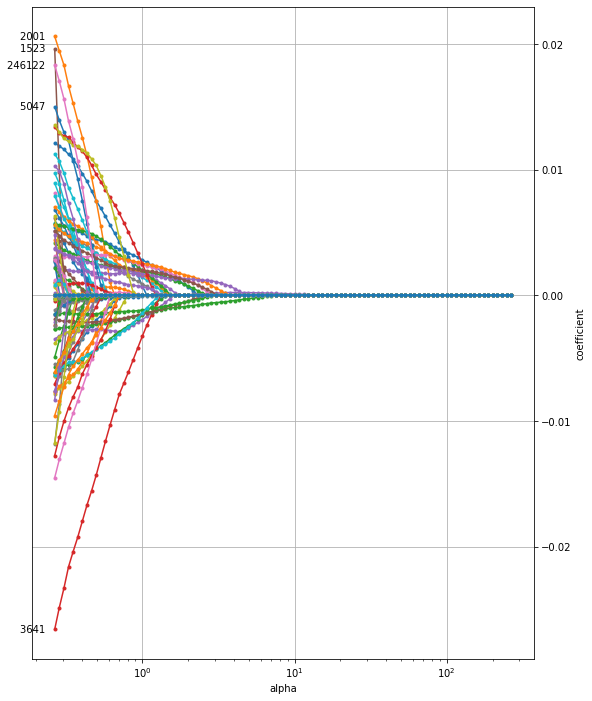

In [30]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.001)
cox_lasso_reg = cox_lasso.fit(Xn, yn)

coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=Xn.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)

def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 12))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")
    
plot_coefficients(coefficients_lasso, n_highlight=5)

In [31]:
#Evaluate the performence
#Lasso regression model
print("\nLasso Model............................................\n")
#cox_lasso = CoxnetSurvivalAnalysis(alpha = 10)
cox_lasso.fit(Xn,yn)
score_ls =cox_lasso.score(Xn,yn)


print("The score for ls model is {}".format(score_ls))



Lasso Model............................................

The score for ls model is 0.8200004234686316


Elastic Net

In [32]:
#Elastic Net

cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001)
cox_en_reg = cox_elastic_net.fit(Xn, yn)

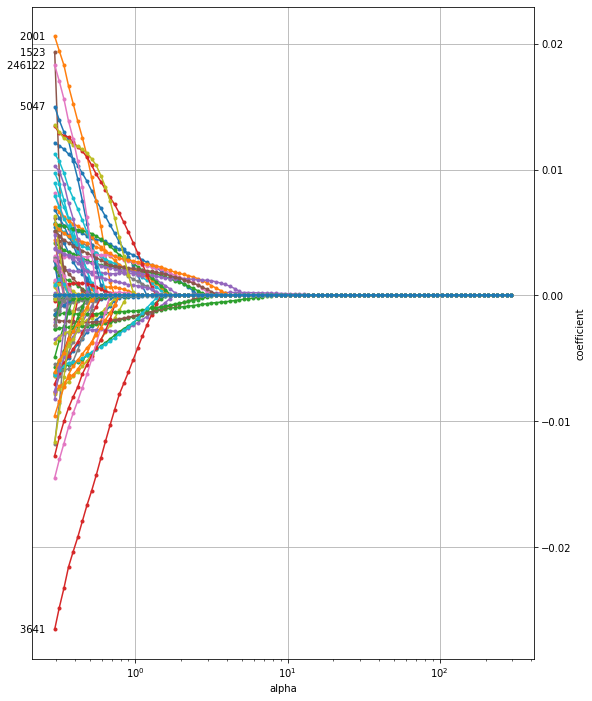

In [33]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_,
    index=Xn.columns,
    columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=5)

In [34]:
print("\nLasso Model............................................\n")
#cox_lasso = CoxnetSurvivalAnalysis(alpha = 10)
cox_elastic_net.fit(Xn,yn)
score_ls =cox_elastic_net.score(Xn,yn)


print("The score for elastic net model is {}".format(score_ls))


Lasso Model............................................

The score for elastic net model is 0.8198733828791632
